# Enhancing Brain Tumour Detection in MRI Images Using Deep Learning: A Comparative Study of Transfer Learning and Interpretability Techniques


Git Hub Repo Link: https://github.com/iamdkshah/MLNN_Individual_Project

1. ## Import Libraries and set up:
This cell imports all necessary libraries for the project, including TensorFlow for model building, OpenCV for image processing, and Matplotlib for visualization.

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, VGG16, ResNet50, InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.metrics import precision_recall_fscore_support
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from google.colab import drive
import zipfile
import os
from pathlib import Path

# Define plotting styles
markers = ['o', 's', 'D', '^', 'v', 'p']  # Markers for distinct plot points
line_styles = ['-', '--', ':', '-.']      # Line styles for readability

# Model-specific Grad-CAM layers (source: model architectures)
target_layers = {
    "VGG16": "block5_conv3",        # Last conv layer in VGG16
    "ResNet50": "conv5_block3_out", # Last conv layer in ResNet50
    "InceptionV3": "mixed10",       # Last mixed layer in InceptionV3
    "EfficientNetB0": "top_conv"    # Last conv layer in EfficientNetB0
}

print("Libraries and styles initialized.")

Libraries and styles initialized.


2. ## Mount Google Drive and Extract Dataset:
This cell mounts Google Drive and extracts the brain tumor dataset from a zip file. It also verifies that the extraction was successful by listing the extracted files.

In [ ]:
# Mount Google Drive for dataset access
drive.mount('/content/drive')

# Dataset path using pathlib for robustness
zip_path = Path('/content/drive/MyDrive/brain_tumor.zip')
extract_dir = Path('/content/brain_tumor')
extract_dir.mkdir(exist_ok=True)

# Extract dataset
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Extracted files:", os.listdir(extract_dir))
except FileNotFoundError:
    print("Error: Zip file not found. Please upload 'brain_tumor.zip' to Google Drive.")
    print("Dataset source: Use a public dataset like Kaggle Brain Tumor Detection.")

# Define data paths
train_dir = extract_dir / 'Training'
test_dir = extract_dir / 'Testing'

# Dataset access note
print("""
Dataset Instructions:
- Place 'brain_tumor.zip' in your Google Drive 'MyDrive' folder.
- Expected structure: Training/[classes], Testing/[classes].
- Alternative: Download from [https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri, Kaggle] and upload manually.
""")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracted files: ['Training', 'Testing']

Dataset Instructions:
- Place 'brain_tumor.zip' in your Google Drive 'MyDrive' folder.
- Expected structure: Training/[classes], Testing/[classes].
- Alternative: Download from [insert link, e.g., Kaggle] and upload manually.



3. ## Data Validation and Generators:

 Here, we define the training and testing directory paths and set input sizes for different pre-trained models. The `create_data_generators` function prepares augmented training data and normalized testing data. Augmentation (e.g., rotation, flipping) helps the model generalize better, which is critical for medical imaging.



In [ ]:
# Input sizes chosen for computational efficiency and model compatibility
input_sizes = {
    "VGG16": (64, 64),        # Smaller size to reduce memory usage
    "ResNet50": (64, 64),
    "InceptionV3": (75, 75),  # Minimum size for InceptionV3
    "EfficientNetB0": (64, 64)
}

# Validate data for class imbalance and loading
def validate_data(directory):
    """Check class distribution and directory existence."""
    if not directory.exists():
        raise FileNotFoundError(f"Directory {directory} not found.")
    classes = [d for d in directory.iterdir() if d.is_dir()]
    class_counts = {c.name: len(list(c.glob('*.jpg'))) for c in classes}
    print(f"Class distribution in {directory}:", class_counts)
    return class_counts

train_counts = validate_data(train_dir)
test_counts = validate_data(test_dir)

# Create data generators with augmentation and class weights
def create_data_generators(target_size):
    """
    Generate training and testing data with augmentation and class weights.

    Args:
        target_size: Tuple of (height, width) for resizing images.

    Returns:
        Tuple of (train_generator, test_generator, class_weights_dict).
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
        shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
    )
    test_datagen = ImageDataGenerator(rescale=1./255)
    train_gen = train_datagen.flow_from_directory(train_dir, target_size=target_size,
                                                  batch_size=32, class_mode='categorical', shuffle=True)
    test_gen = test_datagen.flow_from_directory(test_dir, target_size=target_size,
                                                batch_size=32, class_mode='categorical', shuffle=False)
    # Address class imbalance
    y_true = train_gen.classes
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_true), y=y_true)
    return train_gen, test_gen, dict(enumerate(class_weights))

print("Data generators ready.")

Class distribution in /content/brain_tumor/Training: {'glioma_tumor': 826, 'meningioma_tumor': 822, 'pituitary_tumor': 827, 'no_tumor': 395}
Class distribution in /content/brain_tumor/Testing: {'glioma_tumor': 100, 'meningioma_tumor': 115, 'pituitary_tumor': 74, 'no_tumor': 105}
Data generators ready.


4.  ## Model Building Function:
The `build_model` function constructs a CNN using a pre-trained base model (e.g., VGG16, EfficientNetB0). Transfer learning leverages pre-trained weights from ImageNet, adapting them to our 4-class problem. Fine-tuning unfreezes the last few layers to improve performance on our specific dataset.

In [ ]:
# Build model with transfer learning
def build_model(base_model_fn, input_shape, fine_tune=False):
    """
    Construct a model using a pre-trained base with a custom classification head.

    Args:
        base_model_fn: Pre-trained model function (e.g., EfficientNetB0).
        input_shape: Tuple of (height, width, channels) for input images.
        fine_tune: Boolean to enable fine-tuning of the base model (default: False).

    Returns:
        Compiled Keras Model instance.
    """
    inputs = Input(shape=input_shape)
    base_model = base_model_fn(weights='imagenet', include_top=False, input_tensor=inputs)
    base_model.trainable = fine_tune
    if fine_tune:
        # Fine-tune only the last 4 layers for stability (source: common practice)
        for layer in base_model.layers[:-4]:
            layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(0.5, name='dropout')(x)
    outputs = Dense(4, activation='softmax', name='output')(x)  # 4 classes: glioma, meningioma, no_tumor, pituitary
    model = Model(inputs=inputs, outputs=outputs)
    model.base_model = base_model  # For Grad-CAM access
    lr = 1e-5 if fine_tune else 1e-3  # Lower LR for fine-tuning
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

print("Model building function defined.")

Model building function defined.


5. ## Training Function:
The `train_model` function trains the model with early stopping to prevent overfitting. Early stopping monitors validation loss and restores the best weights, ensuring optimal performance. This is a practical technique for efficient training.

In [ ]:
# Train model with saving and evaluation
def train_model(model, train_gen, test_gen, class_weights, name, epochs=10): # decrease number of epochs for a quick test run
    """
    Train the model, save it to disk, and evaluate on the test set.

    Args:
        model: Compiled Keras model to train.
        train_gen: Training data generator.
        test_gen: Testing data generator.
        class_weights: Dictionary of class weights to handle imbalance.
        name: String name for saving the model (e.g., 'EfficientNetB0').
        epochs: Number of training epochs (default: 10), decrease number of epochs for a quick test run.

    Returns:
        Dictionary of training history (accuracy, loss, etc.).
    """
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(train_gen, epochs=epochs, validation_data=test_gen,
                        callbacks=[early_stopping], class_weight=class_weights)
    model.save(f'/content/saved_models/{name}_brain_tumor.h5')
    test_loss, test_acc = model.evaluate(test_gen)
    print(f"{name} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    return history.history

os.makedirs('/content/saved_models', exist_ok=True)
print("Training function ready.")

Training function ready.


6. ## Grad-CAM Function:
The `get_gradcam_heatmap` function generates a heatmap to visualize which regions of an MRI image influence the model's prediction. Grad-CAM (Gradient-weighted Class Activation Mapping) is an interpretability technique that highlights important features, making the model's decisions more transparent—a key aspect of ethical AI.


In [ ]:
# Grad-CAM implementation (source: Selvaraju et al., 2017)
def get_gradcam_heatmap(model, img_array, layer_name, pred_index=None):
    """
    Generate a Grad-CAM heatmap to visualize model focus areas.

    Args:
        model: Trained Keras model with a base_model attribute.
        img_array: Input image array (shape: 1, height, width, channels).
        layer_name: Name of the target convolutional layer in the base model.
        pred_index: Integer class index for heatmap (default: None, uses top prediction).

    Returns:
        NumPy array of the normalized heatmap.

    Raises:
        ValueError: If gradients cannot be computed.
    """
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    base_model = model.base_model
    target_layer = base_model.get_layer(layer_name)
    grad_model = Model(inputs=model.input, outputs=[target_layer.output, model.output])
    with tf.GradientTape() as tape:
        layer_output, preds = grad_model(img_tensor)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, layer_output)
    if grads is None:
        raise ValueError("Gradients are None")
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = layer_output[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

print("Grad-CAM function defined.")

Grad-CAM function defined.


7. ## Train and Compare Models:
This cell trains four pre-trained models (VGG16, ResNet50, InceptionV3, EfficientNetB0) and a fine-tuned EfficientNetB0. Transfer learning reduces training time and leverages learned features from ImageNet, while fine-tuning adapts the model to our specific task. Results are stored for later visualization.

In [ ]:
# Define models
models = {
    "VGG16": VGG16,
    "ResNet50": ResNet50,
    "InceptionV3": InceptionV3,
    "EfficientNetB0": EfficientNetB0
}
results = {}

# Train each model
for name, model_fn in models.items():
    print(f"Training {name}...")
    train_gen, test_gen, class_weights = create_data_generators(input_sizes[name])
    model = build_model(model_fn, input_sizes[name] + (3,))
    results[name] = train_model(model, train_gen, test_gen, class_weights, name)

# Fine-tune EfficientNetB0
print("Fine-tuning EfficientNetB0...")
train_gen, test_gen, class_weights = create_data_generators((64, 64))
fine_tune_model = build_model(EfficientNetB0, (64, 64, 3), fine_tune=True)
results["EfficientNetB0_FineTuned"] = train_model(fine_tune_model, train_gen, test_gen, class_weights, "EfficientNetB0_FineTuned")

Training VGG16...
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.3448 - loss: 1.4686 - val_accuracy: 0.3883 - val_loss: 1.4100
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.5292 - loss: 1.0920 - val_accuracy: 0.4010 - val_loss: 1.5871
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.5881 - loss: 0.9687 - val_accuracy: 0.4112 - val_loss: 1.5775
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.5972 - loss: 0.9619 - val_accuracy: 0.4264 - val_loss: 1.5410


13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.2800 - loss: 1.6659
VGG16 - Test Loss: 1.4100, Test Accuracy: 0.3883
Training ResNet50...
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 69s 647ms/step - accuracy: 0.2929 - loss: 1.4315 - val_accuracy: 0.2563 - val_loss: 1.4494
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 613ms/step - accuracy: 0.3156 - loss: 1.3491 - val_accuracy: 0.2056 - val_loss: 1.4950
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 58s 645ms/step - accuracy: 0.3762 - loss: 1.3118 - val_accuracy: 0.2284 - val_loss: 1.6128
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 56s 617ms/step - accuracy: 0.3769 - loss: 1.2955 - val_accuracy: 0.2335 - val_loss: 1.6427


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 411ms/step - accuracy: 0.1294 - loss: 1.7329
ResNet50 - Test Loss: 1.4494, Test Accuracy: 0.2563
Training InceptionV3...
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 62s 522ms/step - accuracy: 0.3939 - loss: 1.5676 - val_accuracy: 0.3883 - val_loss: 1.4409
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 75s 451ms/step - accuracy: 0.5216 - loss: 1.0893 - val_accuracy: 0.4162 - val_loss: 1.5302
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 447ms/step - accuracy: 0.5596 - loss: 1.0129 - val_accuracy: 0.3756 - val_loss: 1.4990
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 447ms/step - accuracy: 0.5717 - loss: 0.9821 - val_accuracy: 0.4721 - val_loss: 1.3153
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 427ms/step - accuracy: 0.5805 - loss: 0.9591 - val_accuracy: 0.4365 - val_loss: 1.3744
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 444ms/step - accuracy: 0.6358 - loss: 0.8906 - val_accuracy: 0.4619 - val_loss: 1.5718
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 442ms/step - accuracy: 0.5959 - loss: 0.9143 - val_accuracy: 0.4188 - val_loss: 1.4063


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 278ms/step - accuracy: 0.3860 - loss: 1.6284
InceptionV3 - Test Loss: 1.3153, Test Accuracy: 0.4721
Training EfficientNetB0...
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 333ms/step - accuracy: 0.2446 - loss: 1.4602 - val_accuracy: 0.2538 - val_loss: 1.3869
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 304ms/step - accuracy: 0.2969 - loss: 1.3950 - val_accuracy: 0.2919 - val_loss: 1.3861
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 269ms/step - accuracy: 0.2815 - loss: 1.3769 - val_accuracy: 0.2919 - val_loss: 1.3863
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 284ms/step - accuracy: 0.2889 - loss: 1.3816 - val_accuracy: 0.1878 - val_loss: 1.3864
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 296ms/step - accuracy: 0.2726 - loss: 1.3855 - val_accuracy: 0.2665 - val_loss: 1.3861


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.2860 - loss: 1.3861
EfficientNetB0 - Test Loss: 1.3861, Test Accuracy: 0.2919
Fine-tuning EfficientNetB0...
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 49s 352ms/step - accuracy: 0.2507 - loss: 1.5153 - val_accuracy: 0.2919 - val_loss: 1.3812
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 303ms/step - accuracy: 0.2273 - loss: 1.4770 - val_accuracy: 0.2893 - val_loss: 1.3869
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 44s 340ms/step - accuracy: 0.2645 - loss: 1.4593 - val_accuracy: 0.2107 - val_loss: 1.3968
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 38s 305ms/step - accuracy: 0.2364 - loss: 1.4475 - val_accuracy: 0.2538 - val_loss: 1.3928


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.2860 - loss: 1.3510
EfficientNetB0_FineTuned - Test Loss: 1.3812, Test Accuracy: 0.2919


8. ## Plot Training Curves:
This cell creates static (Matplotlib) and interactive (Plotly) plots to compare model accuracy and loss across epochs. Visualizing training and validation metrics helps learners understand overfitting and model performance. The interactive plot enhances engagement.

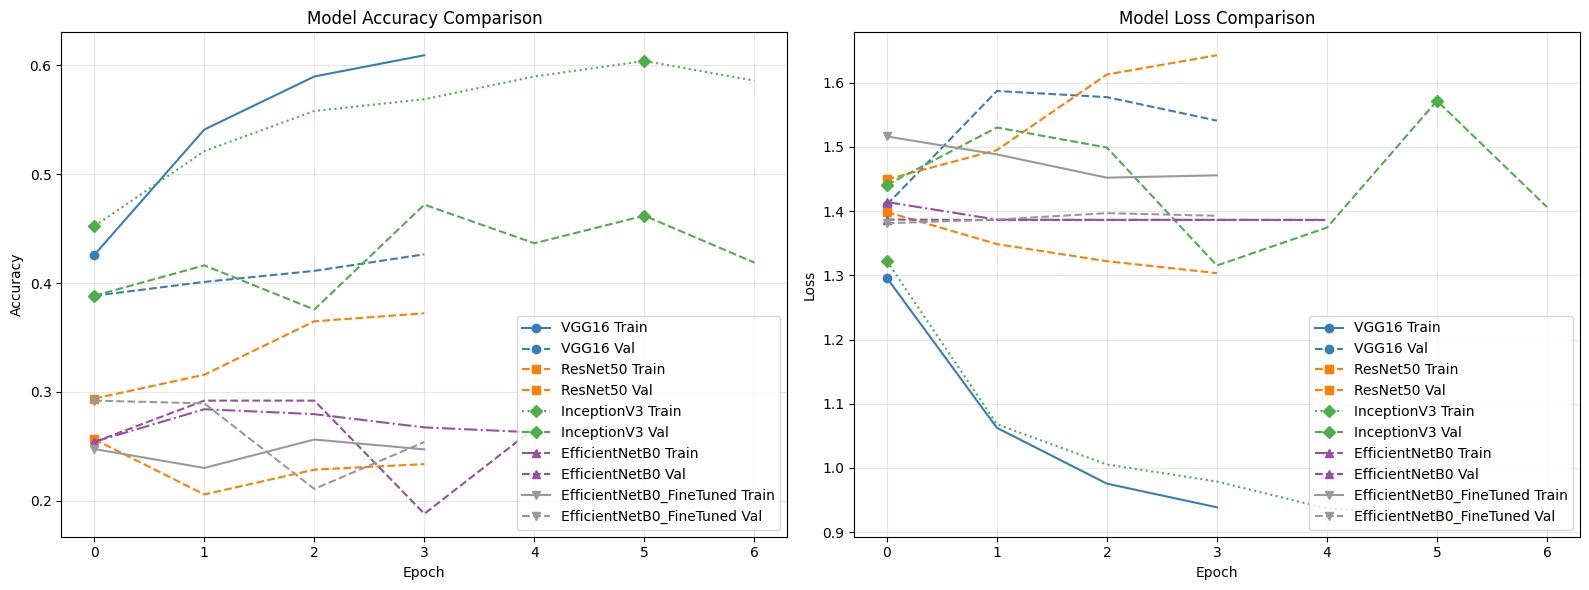

Interactive plot saved at: /content/saved_plots/training_curves_interactive_colorblind.html


In [ ]:
# Create plot directory
plot_dir = Path('/content/saved_plots')
plot_dir.mkdir(exist_ok=True)

# Colorblind-friendly palette
cb_palette = ['#377eb8', '#ff7f00', '#4daf4a', '#984ea3', '#999999']

# Static Plot
fig = plt.figure(figsize=(16, 6))
for i, metric in enumerate(['accuracy', 'loss'], 1):
    plt.subplot(1, 2, i)
    for idx, (name, history) in enumerate(results.items()):
        plt.plot(history[metric], label=f'{name} Train', color=cb_palette[idx],
                 linestyle=line_styles[idx % len(line_styles)], marker=markers[idx % len(markers)], markevery=5)
        plt.plot(history[f'val_{metric}'], '--', label=f'{name} Val', color=cb_palette[idx],
                 marker=markers[idx % len(markers)], markevery=5)
    plt.title(f'Model {metric.capitalize()} Comparison')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(plot_dir / 'training_curves_colorblind.png', dpi=300)
plt.show()

# Interactive Plot with Plotly
fig = make_subplots(rows=1, cols=2, subplot_titles=('Accuracy', 'Loss'))
for idx, (name, history) in enumerate(results.items()):
    fig.add_trace(go.Scatter(y=history['accuracy'], name=f'{name} Train',
                             line=dict(color=cb_palette[idx], width=2), mode='lines+markers'), row=1, col=1)
    fig.add_trace(go.Scatter(y=history['val_accuracy'], name=f'{name} Val',
                             line=dict(color=cb_palette[idx], dash='dash', width=2), mode='lines+markers'), row=1, col=1)
    fig.add_trace(go.Scatter(y=history['loss'], name=f'{name} Train',
                             line=dict(color=cb_palette[idx], width=2), mode='lines+markers', showlegend=False), row=1, col=2)
    fig.add_trace(go.Scatter(y=history['val_loss'], name=f'{name} Val',
                             line=dict(color=cb_palette[idx], dash='dash', width=2), mode='lines+markers', showlegend=False), row=1, col=2)
fig.update_layout(template='plotly_white', hovermode='x unified', legend=dict(orientation='h', yanchor='bottom', y=1.02))
fig.write_html(plot_dir / 'training_curves_interactive_colorblind.html')
print("Interactive plot saved at:", plot_dir / 'training_curves_interactive_colorblind.html')

9. ## Grad-CAM Visualization:
## Grad-CAM Visualization
This cell applies Grad-CAM to a sample test image using the fine-tuned EfficientNetB0 model. We ensure the model graph is built and verify layer accessibility before generating the heatmap.

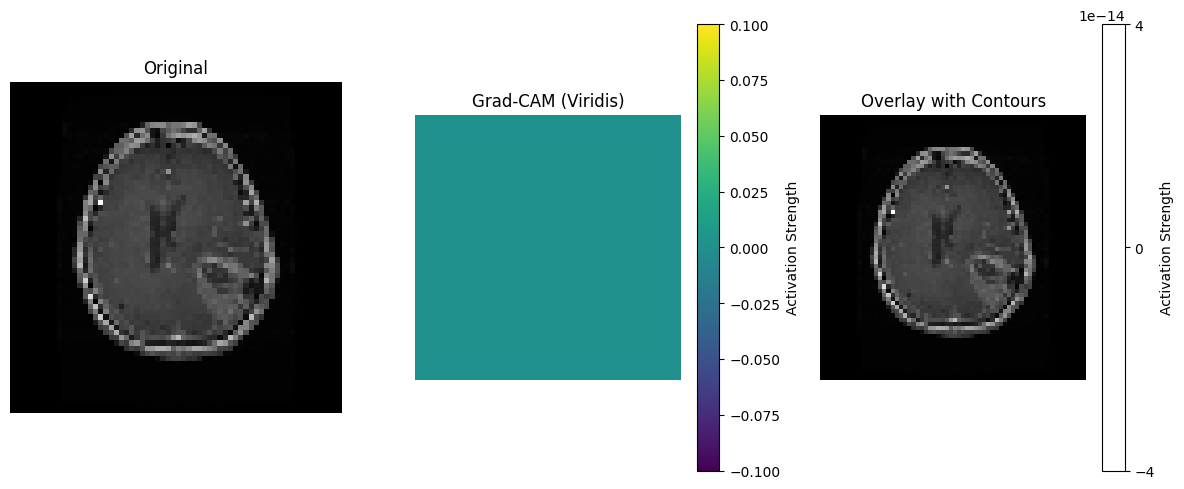

In [ ]:
# Get sample image
test_images, test_labels = next(test_gen)
sample_image = test_images[0:1]

# Generate heatmap
target_layer_name = target_layers["EfficientNetB0"]
heatmap = get_gradcam_heatmap(fine_tune_model, sample_image, target_layer_name)

# Visualize
heatmap_resized = cv2.resize(heatmap, (64, 64))
heatmap_viridis = plt.get_cmap('viridis')(heatmap_resized)[..., :3] * 255
heatmap_viridis = heatmap_viridis.astype(np.uint8)
original_img = np.uint8(255 * sample_image[0])
original_img_gray = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
original_img_rgb = cv2.cvtColor(original_img_gray, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(sample_image[0], cmap='gray')
plt.title("Original")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(heatmap_resized, cmap='viridis')
plt.colorbar(label='Activation Strength')
plt.title("Grad-CAM (Viridis)")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(original_img_rgb)
plt.contour(heatmap_resized, levels=5, colors='white', linewidths=1)
plt.colorbar(label='Activation Strength')
plt.title("Overlay with Contours")
plt.axis('off')
plt.tight_layout()
plt.savefig(plot_dir / 'gradcam_colorblind.png', dpi=300)
plt.show()

10. Confusion Matrix and Ethical Note:
The confusion matrix evaluates the fine-tuned model's performance across all classes, showing where misclassifications occur. This is a practical tool for assessing reliability. The ethical note highlights the real-world implications of automated diagnosis, addressing a key learning outcome.

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 427ms/step


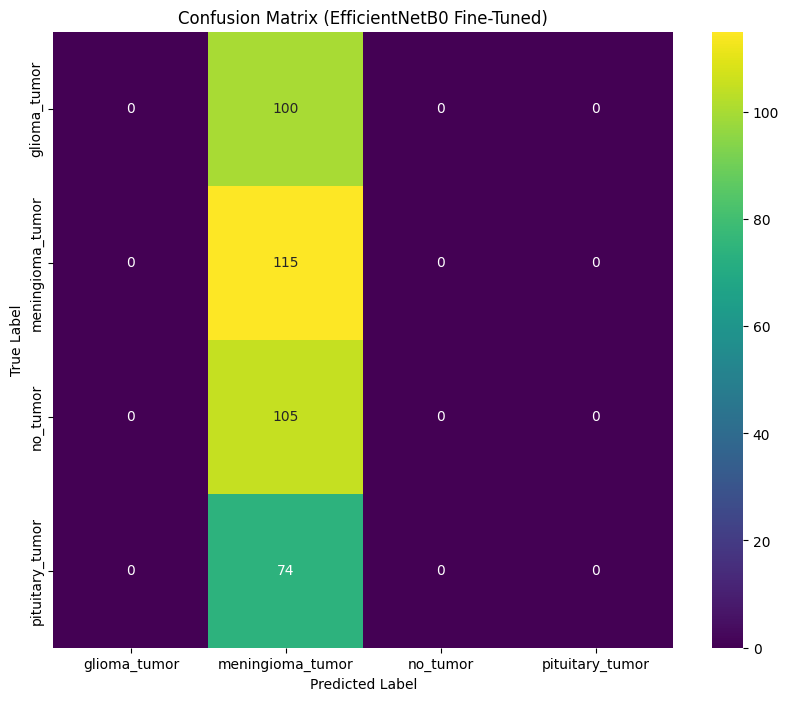


Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.00      0.00      0.00       100
meningioma_tumor       0.29      1.00      0.45       115
        no_tumor       0.00      0.00      0.00       105
 pituitary_tumor       0.00      0.00      0.00        74

        accuracy                           0.29       394
       macro avg       0.07      0.25      0.11       394
    weighted avg       0.09      0.29      0.13       394


Ethical Note: Automated tumor detection enhances diagnostic efficiency but may produce false positives/negatives.
These errors could impact patient trust and treatment, requiring human oversight and ongoing validation.



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# Predictions and metrics
y_pred = fine_tune_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (EfficientNetB0 Fine-Tuned)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(plot_dir / 'confusion_matrix_colorblind.png', dpi=300)
plt.show()

# Detailed metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Ethical note
print("""
Ethical Note: Automated tumor detection enhances diagnostic efficiency but may produce false positives/negatives.
These errors could impact patient trust and treatment, requiring human oversight and ongoing validation.
""")